``lux.ai - Curso de Fotografia Computacional - Aprendizado de Máquina e Profundo``

## Classificação com MLP em PyTorch

Já utilizamos uma rede MLP para fazer a classificação de dígitos com sklearn. Também realizamos testes com nosso modelo em dados advindos do PyTorch.
Nesse colab vamos utilizar uma MLP novamente para realizar a classficação de roupas utilizando o PyTorch para treinamento no dataset FashionMNIST.

```OBS: Quando pedido, realize a operação na célula correspondente atribuindo o resultado na variável indicada. Não altere os nomes das variáveis utilizadas. Você pode utilizar celular adicionais para realizar testes, utilizando variaveis auxiliares para visualizar resultados intermediários.```

### 01 - Imports

In [25]:
%%capture
!pip install torchsummary

# modelagem e dados
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils import data


# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### 02 - Datasets e Dataloaders

Utilizaremos o FashionMNIST, que é composto por 70000 imagens no formato 28x28 pixels caracterizando um problema de classificação de imagens em preto e branco de diferentes roupas e calçados.

In [26]:
print(datasets.FashionMNIST.__doc__)

`Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``FashionMNIST/raw/train-images-idx3-ubyte``
            and  ``FashionMNIST/raw/t10k-images-idx3-ubyte`` exist.
        train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
            otherwise from ``t10k-images-idx3-ubyte``.
        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    


Q1 - O FashionMNIST possui apenas um partição de treino e uma de teste.
 - Utilize o padrão do train_ds para gerar o test_ds
 - Divida o train_ds gerando um valid_ds com 15% dos dados (utilize o data.random_split)

 Refs:

 Dataloaders e datasets: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


In [27]:
transform = transforms.ToTensor()

train_ds = datasets.FashionMNIST(
    root = ".",
    train = True,
    download = True,
    transform = transform
)


valid_ration = 0.15
val_size = int(valid_ration*len(train_ds))
train_size = len(train_ds) - val_size

train_ds, valid_ds = data.random_split(train_ds, [train_size, val_size])

test_ds  = datasets.FashionMNIST(
    root = ".",
    train = False,
    download = True,
    transform = transform
)

Q2 - Crie os dataloaders para o conjunto de validação, treino e teste.
Utilize os batchs de treino, validação e teste como 128.
Defina o num_workers como 2 e mantenha o shuffle e pin_memory habilitado (True).

In [28]:
train_dl = data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

test_dl  = data.DataLoader(test_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

valid_dl = data.DataLoader(valid_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

### 03 - Visualizando dados

Vamos visualizar alguns exemplos da base de dados carregada

In [29]:
samples, targets = next(iter(test_dl))
print(samples.shape, targets.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


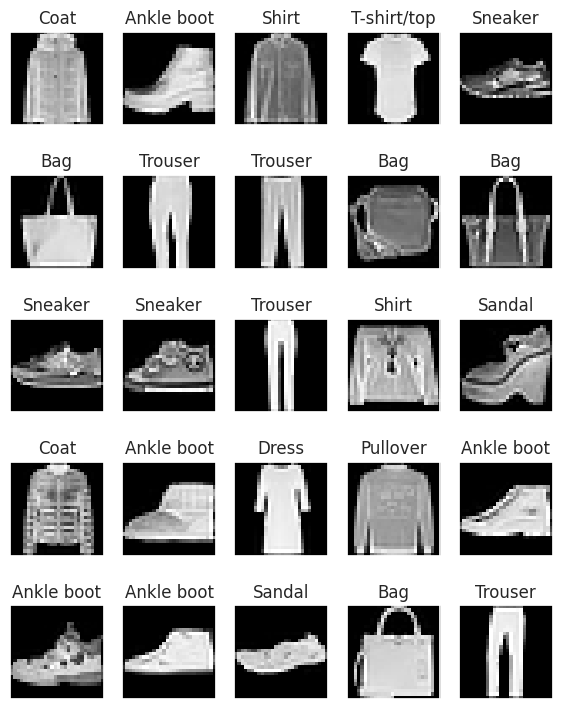

In [30]:
w = 5
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(samples[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = targets[i * w + j].item()
    ax[i][j].set_title(test_ds.classes[int(label)])
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

### 04 - Criação do modelo

Q3 - Agora iremos criar o modelo com PyTorch.

Crie a classe MyMLP que herda de nn.Module.
A sua classe deve conter em sequência:
- 01 - Uma camada Linear de dimensão (in=n, out=256) (nn.Linear)
- 02 - Ativação ReLU (nn.ReLU)
- 03 - Uma camada Linear de dimensão (in=256, out=o)

** Lembrando que n é a dimensão da entrada 28x28 (para a MLP precisamos redimensionar a entrada para um vetor unidimensional, dica: utilize a função nn.Flatten() antes de passar pela camada Linear).
"o" deve ser o numero de classes que queremos classificar (10).
Defina o modelo de tal forma que possamos instancia-lo como MyMLP(n, o).

** Note que todo modelo do PyTorch deve conter o método `__init__` onde criamos as camadas e o `forward` onde realizamos a inferência.

** A segunda camada linear não possuirá ativação, vamos retornar o vetor de predição diretamente

Seu modelo deve ser parecido com o seguinte resultado:

```
MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)
```

Refs:

Gerando modelos: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

nn.Flatten: https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html

nn.Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

nn.ReLU: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html


In [31]:

class MyMLP(nn.Module):
  def __init__(self, n, o):
    super(MyMLP, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
            nn.Linear(n, 256),
            nn.ReLU(),
            nn.Linear(256, o),
        )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = MyMLP(28*28,10).to(DEVICE)
print(model)

MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [32]:
summary(model, input_size=(1,28,28), batch_size=128, device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 256]         200,960
              ReLU-3                 [128, 256]               0
            Linear-4                  [128, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.78
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


### 05 - Loss e Otimização

Q4 - Defina a função de loss utilizando o nn.CrossEntropyLoss e, o otimizador como o optim.Adam. Utilize no Adam os parametros do seu modelo (model) e learning rate = 1E-4

Refs:

Cross Entropy: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Optimizers: https://pytorch.org/docs/stable/optim.html

In [33]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 06 - Definindo os passos de treinamento e validação

Q5 - Complete a função train_step e valid_step para que possamos realizar a otimização e avaliação do modelo.
- Lembre de setar o modelo para cada passo de forma correta (e.g., train e eval).
- Os exemplos e as labels devem estar no mesmo DEVICE que o modelo

In [34]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum/self.count

In [35]:
def train_step(model, train_dl, loss_fn, optimizer, device):

  # ative o modelo com o modo de treino
  model.train()
  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:

    # mova o batch e os rotulos para o mesmo dispositivo do modelo
    train_instances, instance_labels = train_instances.to(device), instance_labels.to(device)
    # faça a previsão com o modelo
    logits = model(train_instances)

    # lembre de zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcule o loss
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # agora faça o backpropagation
    loss.backward()

    # atualize os parâmetros da rede
    optimizer.step()
  return train_loss.avg

In [36]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()
  val_loss = AverageMeter()

  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mova o batch e os rotulos para o mesmo dispositivo do modelo
      val_instances, instance_labels = val_instances.to(device), instance_labels.to(device)

      # faça previsão com o modelo
      logits = model(val_instances)

      # calcule o loss
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))

  return val_loss.avg

### 07 - Treinamento do modelo

Vamos executar o modelo utilizando o train_step e valid_step que definimos anteriormente.

Q6 - Complete o código para realizar o treinamento.

In [37]:
history = {
    "train_loss": [],
    "val_loss": []
}

EPOCHS = 50 # numero de vezes que iteramos no dataset

for epoch in range(EPOCHS):
  # complete com train_step e valid_step utilizando os valores definidos anteriormente
  train_loss = train_step(model, train_dl, loss_fn, optimizer, DEVICE)
  val_loss = validation_step(model, valid_dl, loss_fn, DEVICE)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/50]
-----------------------------------
Train loss: 1.031244
Valid. loss: 0.653276

Época [2/50]
-----------------------------------
Train loss: 0.599804
Valid. loss: 0.535716

Época [3/50]
-----------------------------------
Train loss: 0.521631
Valid. loss: 0.489251

Época [4/50]
-----------------------------------
Train loss: 0.483561
Valid. loss: 0.462572

Época [5/50]
-----------------------------------
Train loss: 0.458572
Valid. loss: 0.447034

Época [6/50]
-----------------------------------
Train loss: 0.440901
Valid. loss: 0.435991

Época [7/50]
-----------------------------------
Train loss: 0.426463
Valid. loss: 0.419135

Época [8/50]
-----------------------------------
Train loss: 0.414744
Valid. loss: 0.411967

Época [9/50]
-----------------------------------
Train loss: 0.404818
Valid. loss: 0.399721

Época [10/50]
-----------------------------------
Train loss: 0.3955 
Valid. loss: 0.399888

Época [11/50]
-----------------------------------
Train loss: 0.388354

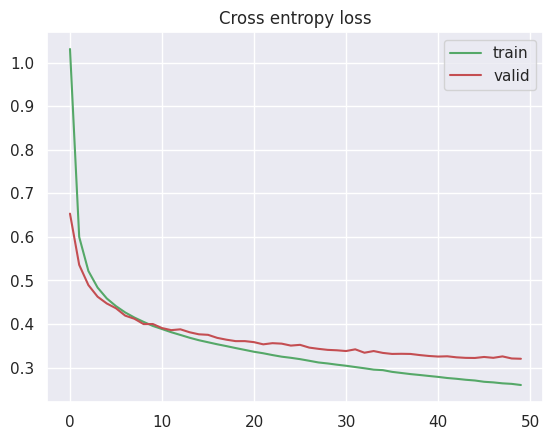

In [38]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

### 08 - Teste

Q7 - Por fim, vamos avaliar nosso modelo no conjunto de teste

- Defina o modelo como avaliação
- passe os exemplos para o device em uso
- faça a predição com o modelo
- obtenha o vetor de probabilidades a partir da saída do modelo (i.e., use o nn.functional.softmax)
- obtenha o indice (numero da classe) que contém o valor máximo de probabilidade (use o torch.argmax)

In [42]:
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0

# 1 defina o modelo para avaliação (eval)
## insira o código aqui
model.eval()

for test_instances, instance_labels in test_dl:

    # 2 mova o batch e os rotulos para o mesmo dispositivo do modelo
    test_instances, instance_labels = test_instances.to(DEVICE), instance_labels.to(DEVICE)

    with torch.no_grad():
        # 3 faça a predição
        logits = model(test_instances)

    # 4 obtenha o vetor de probabilidades
    probs = nn.functional.softmax(logits, 1)

    # 5 obtenha a classe com max prob
    preds = torch.argmax(probs, 1)

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))


preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

Vamos visualizar o resultado a partir da matriz de confusão

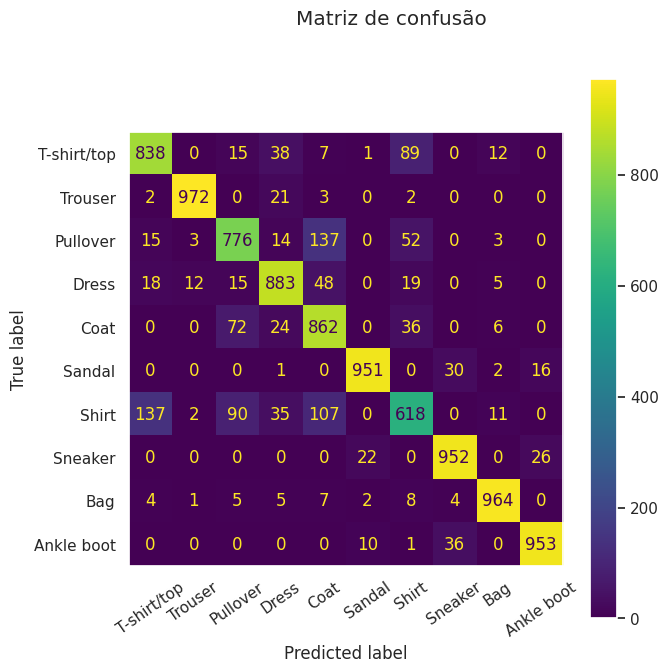

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = test_ds.classes

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [44]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.84      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.80      0.78      0.79      1000
       Dress       0.86      0.88      0.87      1000
        Coat       0.74      0.86      0.79      1000
      Sandal       0.96      0.95      0.96      1000
       Shirt       0.75      0.62      0.68      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.96      0.96      0.96      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

